# **멜론 월간차트 검색**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pip install & Import

In [ ]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

  Using cached urllib3-1.26.7-py2.py3-none-any.whl (138 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uninstalled urllib3-1.25.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos

In [ ]:
!set -x \ && pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

+ pip install konlpy
  Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.7
    Uninstalling urllib3-1.26.7:
      Successfully uninstalled urllib3-1.26.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
selenium 4.1.0 requires urllib3[secure]~=1.26, but you have urllib3 1.25.11 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
+ curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
+ bash -x
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ hash mecab
+ echo 'mecab-ko is

In [ ]:
### 아래 셀 실행후 런타임 다시시작 해줌.

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.style.use('seaborn-white')

%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size =10)
plt.rc('font', family='NanumBarunGothic')   # 나눔바른고딕 폰트 설치
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 55 not upgraded.


In [ ]:
import selenium
from selenium import webdriver as wd
#from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import time
import pandas as pd
from bs4 import BeautifulSoup
import requests
from itertools import repeat
import numpy as np
import matplotlib.ticker as ticker

## Preprocess

In [ ]:
options = wd.ChromeOptions()
options.add_argument('--headless')        # Head-less 설정
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# 크롬드라이버 열기
driver = wd.Chrome('chromedriver', options=options)
driver.maximize_window() # 크롬창 크기 최대

In [ ]:
def find_song_numbers(soup):
    song_button = [title.find('button') for title in soup.find_all('div', attrs={'class': 'wrap'})]
    song_num = []
    pre=""
    for elem in song_button :
        if elem != None:
            a = str(elem)
            res = ""
            if "data-song-no" in a:
                indx = a.find("data-song-no=")+len("data-song-no=")
                i = 1
                while True:
                    if a[indx+i] == '"':
                        break;
                    res+= a[indx+i]
                    i+=1
                if not res == pre:
                    song_num.append(res)
                pre = res
    return song_num

# 가사 추출
def scraping_lyrics(song_num):
    LYRICs = []
    for i in song_num:
        driver.get("https://www.melon.com/song/detail.htm?songId=" + i)
        lyric=driver.find_element_by_class_name("lyric")
        LYRICs.append(lyric.text)
    
    return LYRICs

# 장르 추출
def scraping_genres(song_num):
    GENREs = []
    for i in song_num:
        driver.get("https://www.melon.com/song/detail.htm?songId=" + i)
        genre=driver.find_element_by_class_name("list").text
        indx = genre.find("장르")
        b = genre.find("\n", indx+3)
        if b == -1:
            GENREs.append(genre[indx+3:])
        else:
            GENREs.append(genre[indx+3:b])
    
    return GENREs

In [ ]:
PATHs = []
for indx in ['1','2','3','4']:
    path = '//*[@id="d_chart_search"]/div/div/div[1]/div[1]/ul/li[' + indx + ']/span/label'
    PATHs.append(path)

Lyrics_2010 = []
Lyrics_2000 = []
Lyrics_1990 = []
Lyrics_1980 = []

### **2010년대 장르 추출**

In [ ]:
# test code - 에러났을때 이거 돌리니까 해결됨. 왜인지는 모름
url = 'https://www.melon.com/chart/index.htm'
driver.get(url)

driver.find_element_by_xpath('//*[@id="gnb_menu"]/ul[1]/li[1]/div/div/button/span').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/h4[4]/a').click()
time.sleep(2)
driver.find_element_by_xpath(PATHs[0]).click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/div/div[5]/div[1]/ul/li[1]/span/label').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_srch_form"]/div[2]/button/span/span').click()
time.sleep(2)

html = driver.page_source 
soup = BeautifulSoup(html, 'lxml')

song_numbers = find_song_numbers(soup)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  del sys.path[0]


In [ ]:
# test
print(song_numbers[0])
options = wd.ChromeOptions()
options.add_argument('--headless')        # Head-less 설정
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# 크롬드라이버 열기
driver = wd.Chrome('chromedriver', options=options)
driver.maximize_window() # 크롬창 크기 최대
driver.get("https://www.melon.com/song/detail.htm?songId=" + song_numbers[0])

genre=driver.find_element_by_class_name("lyric").text
print(genre)

In [ ]:
url = 'https://www.melon.com/chart/index.htm'
driver.get(url)

driver.find_element_by_xpath('//*[@id="gnb_menu"]/ul[1]/li[1]/div/div/button/span').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/h4[4]/a').click()
time.sleep(2)
driver.find_element_by_xpath(PATHs[0]).click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/div/div[5]/div[1]/ul/li[1]/span/label').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_srch_form"]/div[2]/button/span/span').click()
time.sleep(2)

html = driver.page_source 
soup = BeautifulSoup(html, 'lxml')

song_numbers = find_song_numbers(soup)

Genre_2010 = scraping_genres(song_numbers)
print(Genre_2010)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: Depr

['록/메탈', '발라드', '발라드', '랩/힙합', '발라드', '발라드, 국내드라마', '발라드', '발라드, 국내드라마', '발라드', 'R&B/Soul', '발라드, 인디음악', '발라드', '발라드', '발라드', 'R&B/Soul', '댄스', '인디음악, 포크/블루스', '댄스', '발라드', '발라드', 'R&B/Soul', '랩/힙합', '댄스', '랩/힙합', '인디음악, 일렉트로니카', '발라드', '발라드', '랩/힙합', '댄스', '발라드', '랩/힙합', 'R&B/Soul', '인디음악, 포크/블루스', '발라드, 국내드라마', '록/메탈', '댄스', '발라드, R&B/Soul, 국내드라마', '랩/힙합', '댄스', '발라드', '발라드', '발라드', '인디음악, 포크/블루스', 'R&B/Soul', 'R&B/Soul', '댄스', '발라드, 국내드라마', '인디음악, 록/메탈', '발라드', '댄스', '랩/힙합', '국내드라마', '댄스', '발라드', '댄스', 'R&B/Soul', '인디음악, 록/메탈', '발라드, 국내드라마', '댄스', '발라드', '인디음악, 포크/블루스', '랩/힙합', '랩/힙합', '랩/힙합', 'R&B/Soul', 'R&B/Soul', '댄스', 'R&B/Soul', '발라드', '발라드', '발라드', '인디음악, 록/메탈', '댄스', '발라드', '발라드, 국내드라마', '댄스', '발라드', '발라드, 랩/힙합, 국내드라마', '발라드', '댄스', '댄스', '발라드', '록/메탈', '발라드, 국내드라마', '발라드', '발라드', 'R&B/Soul', '발라드', '랩/힙합', '포크/블루스', '랩/힙합', '발라드', '랩/힙합', '댄스', '포크/블루스', '발라드', 'R&B/Soul', 'R&B/Soul', '인디음악, 포크/블루스', '발라드, 국내드라마']


### 2000년대 장르 추출

In [ ]:
url = 'https://www.melon.com/chart/index.htm'
driver.get(url)

driver.find_element_by_xpath('//*[@id="gnb_menu"]/ul[1]/li[1]/div/div/button/span').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/h4[4]/a').click()
time.sleep(2)
driver.find_element_by_xpath(PATHs[1]).click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/div/div[5]/div[1]/ul/li[1]/span/label').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_srch_form"]/div[2]/button/span/span').click()
time.sleep(2)

html = driver.page_source 
soup = BeautifulSoup(html, 'lxml')

song_numbers = find_song_numbers(soup)

Genre_2000 = scraping_genres(song_numbers)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: Depr

### 1990년대 장르 추출

In [ ]:
url = 'https://www.melon.com/chart/index.htm'
driver.get(url)

driver.find_element_by_xpath('//*[@id="gnb_menu"]/ul[1]/li[1]/div/div/button/span').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/h4[4]/a').click()
time.sleep(2)
driver.find_element_by_xpath(PATHs[2]).click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/div/div[5]/div[1]/ul/li[1]/span/label').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_srch_form"]/div[2]/button/span/span').click()
time.sleep(2)

html = driver.page_source 
soup = BeautifulSoup(html, 'lxml')

song_numbers = find_song_numbers(soup)

Genre_1990 = scraping_genres(song_numbers)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: Depr

### 1980년대 장르 추출

In [ ]:
url = 'https://www.melon.com/chart/index.htm'
driver.get(url)

driver.find_element_by_xpath('//*[@id="gnb_menu"]/ul[1]/li[1]/div/div/button/span').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/h4[4]/a').click()
time.sleep(2)
driver.find_element_by_xpath(PATHs[3]).click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/div/div[5]/div[1]/ul/li[1]/span/label').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_srch_form"]/div[2]/button/span/span').click()
time.sleep(2)

html = driver.page_source 
soup = BeautifulSoup(html, 'lxml')
print(soup.find_all('div', attrs={'class': 'ellipsis rank01'})[:5])

song_numbers = find_song_numbers(soup)

Genre_1980 = scraping_genres(song_numbers)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  if sys.path[0] == '':


[<div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','1138841');" title="가까이 하기엔 너무 먼 당신 재생 - 새창">가까이 하기엔 너무 먼 당신</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','59253');" title="가나다라 재생 - 새창">가나다라</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','111369');" title="가슴앓이 재생 - 새창">가슴앓이</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','987282');" title="가시나무 재생 - 새창">가시나무</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','1125932');" title="가을을 남기고 간 사랑 재생 - 새창">가을을 남기고 간 사랑</a></strong>
</span></div>]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead


### Test

In [ ]:
for genre in Genre_2010:
    print(genre)

록/메탈
발라드
발라드
랩/힙합
발라드
발라드, 국내드라마
발라드
발라드, 국내드라마
발라드
R&B/Soul
발라드, 인디음악
발라드
발라드
발라드
R&B/Soul
댄스
인디음악, 포크/블루스
댄스
발라드
발라드
R&B/Soul
랩/힙합
댄스
랩/힙합
인디음악, 일렉트로니카
발라드
발라드
랩/힙합
댄스
발라드
랩/힙합
R&B/Soul
인디음악, 포크/블루스
발라드, 국내드라마
록/메탈
댄스
발라드, R&B/Soul, 국내드라마
랩/힙합
댄스
발라드
발라드
발라드
인디음악, 포크/블루스
R&B/Soul
R&B/Soul
댄스
발라드, 국내드라마
인디음악, 록/메탈
발라드
댄스
랩/힙합
국내드라마
댄스
발라드
댄스
R&B/Soul
인디음악, 록/메탈
발라드, 국내드라마
댄스
발라드
인디음악, 포크/블루스
랩/힙합
랩/힙합
랩/힙합
R&B/Soul
R&B/Soul
댄스
R&B/Soul
발라드
발라드
발라드
인디음악, 록/메탈
댄스
발라드
발라드, 국내드라마
댄스
발라드
발라드, 랩/힙합, 국내드라마
발라드
댄스
댄스
발라드
록/메탈
발라드, 국내드라마
발라드
발라드
R&B/Soul
발라드
랩/힙합
포크/블루스
랩/힙합
발라드
랩/힙합
댄스
포크/블루스
발라드
R&B/Soul
R&B/Soul
인디음악, 포크/블루스
발라드, 국내드라마


In [ ]:
def make_genre_dict(Genre):
    Genre_dict = {'발라드': 0, '댄스': 0, '랩/힙합': 0,  'R&B/Soul': 0, '국내드라마': 0, '인디음악': 0, '록/메탈': 0, '트로트': 0, '포크/블루스': 0,
                   'POP': 0, '일렉트로니카': 0, '재즈': 0, '성인가요': 0, '국내영화': 0}

    for genres in Genre:
        genres = genres.split(', ')
    
        for genre in genres:
            Genre_dict[genre] += 1

    return Genre_dict        

In [ ]:
Genre_2010_dict = make_genre_dict(Genre_2010)
Genre_2000_dict = make_genre_dict(Genre_2000)
Genre_1990_dict = make_genre_dict(Genre_1990)
Genre_1980_dict = make_genre_dict(Genre_1980)

In [ ]:
def print_dict(dictionary):
    for key, value in zip(dictionary.keys(), dictionary.values()):
        if value != 0:
         print(f'{key} : {value}곡')

In [ ]:
print("\n==== 1980년대 ====\n")
print_dict(Genre_1980_dict)
print("\n==== 1990년대 ====\n")
print_dict(Genre_1990_dict)
print("\n==== 2000년대 ====\n")
print_dict(Genre_2000_dict)
print("\n==== 2010년대 ====\n")
print_dict(Genre_2010_dict)


==== 1980년대 ====

발라드 : 38곡
댄스 : 6곡
록/메탈 : 9곡
포크/블루스 : 17곡
성인가요 : 32곡

==== 1990년대 ====

발라드 : 61곡
댄스 : 11곡
R&B/Soul : 1곡
국내드라마 : 1곡
록/메탈 : 15곡
포크/블루스 : 8곡
성인가요 : 4곡
국내영화 : 2곡

==== 2000년대 ====

발라드 : 47곡
댄스 : 33곡
랩/힙합 : 8곡
R&B/Soul : 12곡
록/메탈 : 8곡

==== 2010년대 ====

발라드 : 42곡
댄스 : 17곡
랩/힙합 : 14곡
R&B/Soul : 14곡
국내드라마 : 11곡
인디음악 : 10곡
록/메탈 : 6곡
포크/블루스 : 7곡
일렉트로니카 : 1곡


In [ ]:


print(Genre_2010_dict)
print(Genre_2000_dict)
print(Genre_1990_dict)
print(Genre_1980_dict)

In [ ]:
key = []
val = []

for k in Genre_2010_dict:
    key.append(k)

for e1, e2, e3, e4 in zip(Genre_2010_dict.values(), Genre_2000_dict.values(), Genre_1990_dict.values(), Genre_1980_dict.values()):
    val.append(e1)
    val.append(e2)
    val.append(e3)
    val.append(e4)

In [ ]:
y_pos = np.arange(0, len(Genre_2010_dict)*2, 2)

width = 0.3

fig, axes = plt.subplots(figsize=(15,15))

axes.barh(y_pos - width*3/2, Genre_2010_dict.values(), width, alpha = 0.5, color = "green")
axes.barh(y_pos - width/2, Genre_2000_dict.values(), width, alpha = 0.5, color = "blue")
axes.barh(y_pos + width/2, Genre_1990_dict.values(), width, alpha = 0.5, color = "black")
axes.barh(y_pos + width*3/2, Genre_1980_dict.values(), width, alpha = 0.5, color = "red")

plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.yticks(y_pos)

axes.set_yticklabels(key)
plt.xlabel('number of genre')

plt.title("연대별 TOP 100 노래 장르분석\n", fontsize=20)

plt.legend(['2010', '2000', '1990', '1980'], prop={'size': 15})

plt.show()

In [ ]:
y_pos = np.arange(len(Genre_2010_dict)*4)

plt.figure(figsize=(14, 14))
plt.barh(y_pos, val, color='g')
plt.yticks(y_pos, key, color='black')

for i, yi in enumerate(y_pos):
    plt.text(val[i], yi, val[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='black',
             horizontalalignment='left',  # horizontal alignment (left, center, right)
             verticalalignment='bottom')    # vertical alignment (top, center, bottom)

plt.title('2000년대 TOP 100 노래가사 형태소 빈도분석')

# 눈금 간격
ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
# 보조선
plt.grid(True)

plt.show()

### 2010년대 가사추출

In [ ]:
url = 'https://www.melon.com/chart/index.htm'
driver.get(url)

driver.find_element_by_xpath('//*[@id="gnb_menu"]/ul[1]/li[1]/div/div/button/span').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/h4[4]/a').click()
time.sleep(2)
driver.find_element_by_xpath(PATHs[0]).click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/div/div[5]/div[1]/ul/li[1]/span/label').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_srch_form"]/div[2]/button/span/span').click()
time.sleep(2)

html = driver.page_source 
soup = BeautifulSoup(html, 'lxml')
print(soup.find_all('div', attrs={'class': 'ellipsis rank01'})[:5])

song_numbers = find_song_numbers(soup)

Lyrics_2010 = scraping_lyrics(song_numbers)
print(Lyrics_2010[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  if sys.path[0] == '':


[<div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','3753304');" title="벚꽃 엔딩 재생 - 새창">벚꽃 엔딩</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','30314784');" title="밤편지 재생 - 새창">밤편지</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','4543502');" title="야생화 재생 - 새창">야생화</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','30244931');" title="봄날 재생 - 새창">봄날</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','4369827');" title="금요일에 만나요 (Feat. 장이정 Of HISTORY) 재생 - 새창">금요일에 만나요 (Feat. 장이정 Of HISTORY)</a></strong>
</span></div>]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead


그대여 그대여 그대여
그대여 그대여
오늘은 우리 같이 걸어요 이 거리를
밤에 들려오는 자장노래 어떤가요
오예
몰랐던 그대와 단 둘이 손 잡고
알 수 없는 이 떨림과 둘이 걸어요
봄바람 휘날리며
흩날리는 벚꽃 잎이
울려 퍼질 이 거리를
우우 둘이 걸어요
봄바람 휘날리며
흩날리는 벚꽃 잎이
울려 퍼질 이 거리를
우우 둘이 걸어요
오예
그대여 우리 이제 손 잡아요
이 거리에 마침 들려오는
사랑 노래 어떤가요
오예
사랑하는 그대와 단 둘이 손잡고
알 수 없는 이 거리를 둘이 걸어요
봄바람 휘날리며
흩날리는 벚꽃 잎이
울려 퍼질 이 거리를
우우 둘이 걸어요
봄바람 휘날리며
흩날리는 벚꽃 잎이
울려 퍼질 이 거리를
우우 둘이 걸어요
바람 불면 울렁이는 기분 탓에
나도 모르게
바람 불면 저편에서 그대여
니 모습이 자꾸 겹쳐
오 또 울렁이는 기분 탓에
나도 모르게
바람 불면 저편에서 그대여
니 모습이 자꾸 겹쳐
사랑하는 연인들이 많군요
알 수 없는 친구들이 많아요
흩날리는 벚꽃 잎이 많군요 좋아요
봄바람 휘날리며
흩날리는 벚꽃 잎이
울려 퍼질 이 거리를
우우 둘이 걸어요
봄바람 휘날리며
흩날리는 벚꽃 잎이
울려 퍼질 이 거리를
우우 둘이 걸어요
그대여 그대여 그대여
그대여 그대여


### 2000년대 가사 추출

In [ ]:
url = 'https://www.melon.com/chart/index.htm'
driver.get(url)

driver.find_element_by_xpath('//*[@id="gnb_menu"]/ul[1]/li[1]/div/div/button/span').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/h4[4]/a').click()
time.sleep(2)
driver.find_element_by_xpath(PATHs[1]).click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/div/div[5]/div[1]/ul/li[1]/span/label').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_srch_form"]/div[2]/button/span/span').click()
time.sleep(2)

html = driver.page_source 
soup = BeautifulSoup(html, 'lxml')
print(soup.find_all('div', attrs={'class': 'ellipsis rank01'})[:5])

song_numbers = find_song_numbers(soup)

Lyrics_2000 = scraping_lyrics(song_numbers)
print(Lyrics_2000[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  if sys.path[0] == '':


[<div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','2012282');" title="Gee 재생 - 새창">Gee</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','421409');" title="점점 재생 - 새창">점점</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','837567');" title="사랑했나봐 재생 - 새창">사랑했나봐</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','1765767');" title="마지막 인사 재생 - 새창">마지막 인사</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','499230');" title="사랑의 시(時) 재생 - 새창">사랑의 시(時)</a></strong>
</span></div>]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead


Uh Huh Listen Boy
My First Love Story
My Angel and My Girl
My Sunshine
Uh Uh Let's go
너무 너무 멋져 눈이 눈이 부셔
숨을 못 쉬겠어 떨리는 Girl
Gee Gee Gee Gee Baby Baby Baby
Gee Gee Gee Gee Baby Baby Baby
너무 부끄러워 쳐다 볼 수 없어
사랑에 빠져서 수줍은 Girl
Gee Gee Gee Gee Baby Baby Baby
Gee Gee Gee Gee
Be Be Be Be Be Be
어떻게 하죠
어떡 어떡하죠
떨리는 나는
떨리는 나는요
두근 두근 두근 두근
두근 두근거려
밤엔 잠도 못 이루죠
나는 나는 바본가봐요
그대 그대밖에 모르는 바보
그래요 그댈 보는 난
너무 반짝 반짝 눈이 부셔
No No No No No
너무 깜짝 깜짝 놀란 나는
Oh Oh Oh Oh Oh
너무 짜릿 짜릿 몸이 떨려
Gee Gee Gee Gee Gee
Oh 젖은 눈빛 Oh Yeah
좋은 향기 Oh Yeah Yeah Yeah
너무 너무 예뻐 맘이 너무 예뻐
첫 눈에 반했어 꼭 짚은 Girl
Gee Gee Gee Gee Baby Baby Baby
Gee Gee Gee Gee Baby Baby Baby
너무나 뜨거워 만질 수가 없어
사랑에 타버려 후끈한 Girl
Gee Gee Gee Gee Baby Baby Baby
Gee Gee Gee Gee
Be Be Be Be Be Be
어쩌면 좋아
어쩌면 좋아요
수줍은 나는
수줍은 나는요
몰라 몰라 몰라 몰라
몰라 몰라 하며
매일 그대만 그리죠
친한 친구들은 말하죠
정말 너는 정말 못 말려
바보 하지만 그댈 보는 난
너무 반짝 반짝 눈이 부셔
No No No No No
너무 깜짝 깜짝 놀란 나는
Oh Oh Oh Oh Oh
너무 짜릿 짜릿 몸이 떨려
Gee Gee Gee Gee Gee
Oh 젖은 눈빛 Oh Yeah
좋은 향기 Oh Yeah Yeah Yeah
말도 못했는 걸
너무 부끄러워 하는 난
용기가 없는 걸까
어떡해야 좋은걸까


### 1990년대 가사 추출

In [ ]:
url = 'https://www.melon.com/chart/index.htm'
driver.get(url)

driver.find_element_by_xpath('//*[@id="gnb_menu"]/ul[1]/li[1]/div/div/button/span').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/h4[4]/a').click()
time.sleep(2)
driver.find_element_by_xpath(PATHs[2]).click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/div/div[5]/div[1]/ul/li[1]/span/label').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_srch_form"]/div[2]/button/span/span').click()
time.sleep(2)

html = driver.page_source 
soup = BeautifulSoup(html, 'lxml')
print(soup.find_all('div', attrs={'class': 'ellipsis rank01'})[:5])

song_numbers = find_song_numbers(soup)

Lyrics_1990 = scraping_lyrics(song_numbers)
print(Lyrics_1990[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  if sys.path[0] == '':


[<div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','49933');" title="내사랑 내곁에 (응답하라 1988 삽입곡) 재생 - 새창">내사랑 내곁에 (응답하라 1988 삽입곡)</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','57339');" title="너를 사랑해 재생 - 새창">너를 사랑해</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','7855027');" title="다시 만난 너에게 재생 - 새창">다시 만난 너에게</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','2981575');" title="나의 노래 재생 - 새창">나의 노래</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','50733');" title="아주 오래된 연인들 재생 - 새창">아주 오래된 연인들</a></strong>
</span></div>]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead


나의 모든 사랑이 떠나가는 날이
당신의 그 웃음 뒤에서
함께하는데
철이 없는 욕심에 그 많은 미련에
당신이 있는 건 아닌지
아니겠지요
시간은 멀어 집으로 향해가는데
약속했던 그대만은
올 줄을 모르고
애써 웃음지으며 돌아오는 길은
왜 그리도 낯설고 멀기만 한지
저 여린 가지 사이로
혼자인 날 느낄때
이렇게 아픈 그대 기억이 날까
내 사랑 그대 내 곁에 있어줘
이 세상 하나뿐인 오직 그대만이
힘겨운 날에 너마저 떠나면
비틀거릴 내가 안길 곳은 어디에
저 여린 가지 사이로
혼자인 날 느낄때
이렇게 아픈 그대 기억이 날까
내 사랑 그대 내 곁에 있어줘
이 세상 하나뿐인 오직 그대만이
힘겨운 날에 너마저 떠나면
비틀거릴 내가 안길 곳은 어디에
비틀거릴 내가 안길 곳은 어디에
비틀거릴 내가 안길 곳은 어디에


### 1980년대 가사 추출

In [ ]:
url = 'https://www.melon.com/chart/index.htm'
driver.get(url)

driver.find_element_by_xpath('//*[@id="gnb_menu"]/ul[1]/li[1]/div/div/button/span').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/h4[4]/a').click()
time.sleep(2)
driver.find_element_by_xpath(PATHs[3]).click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/div/div[5]/div[1]/ul/li[1]/span/label').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="d_srch_form"]/div[2]/button/span/span').click()
time.sleep(2)

html = driver.page_source 
soup = BeautifulSoup(html, 'lxml')
print(soup.find_all('div', attrs={'class': 'ellipsis rank01'})[:5])

song_numbers = find_song_numbers(soup)

Lyrics_1980 = scraping_lyrics(song_numbers)
print(Lyrics_1980[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  if sys.path[0] == '':


[<div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','1138841');" title="가까이 하기엔 너무 먼 당신 재생 - 새창">가까이 하기엔 너무 먼 당신</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','59253');" title="가나다라 재생 - 새창">가나다라</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','111369');" title="가슴앓이 재생 - 새창">가슴앓이</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','987282');" title="가시나무 재생 - 새창">가시나무</a></strong>
</span></div>, <div class="ellipsis rank01"><span>
<strong><a href="javascript:melon.play.playSong('19080101','1125932');" title="가을을 남기고 간 사랑 재생 - 새창">가을을 남기고 간 사랑</a></strong>
</span></div>]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead


아 당신은
당신은 누구시길래
내 맘 깊은 곳에
외로움 심으셨나요
그냥 스처 지나갈 바람이라면
모르는 타인들처럼
아무말 말고 가세요
잊으려하면 할수록
그리움이 더욱 하겠지만
가까이 하기엔 너무 먼
당신을 난 난 잊을테요

그냥 스쳐 지나갈 바람이라면
모르는 타인들처럼
아무말 말고 가세요
잊으려면 할수록
그리움이 더욱 더하겠지만
가까이 하기엔 너무 먼
당신을 난 난 잊을테여


### 추출 확인

In [ ]:
len(Lyrics_2010), len(Lyrics_2000), len(Lyrics_1990), len(Lyrics_1980)

(100, 100, 100, 100)

### 파일 저장

In [ ]:
PATH1 = '/content/drive/Shareddrives/Data/e-campus/빅데이터및커뮤니케이션/data/Lyrics_2010.txt'
PATH2 = '/content/drive/Shareddrives/Data/e-campus/빅데이터및커뮤니케이션/data/Lyrics_2000.txt'
PATH3 = '/content/drive/Shareddrives/Data/e-campus/빅데이터및커뮤니케이션/data/Lyrics_1990.txt'

with open(PATH1, 'w', encoding='UTF-8') as f:
    for song in Lyrics_2010:
        f.write(song+'\n||\n')

with open(PATH2, 'w', encoding='UTF-8') as f:
    for song in Lyrics_2000:
        f.write(song+'\n||\n')

with open(PATH3, 'w', encoding='UTF-8') as f:
    for song in Lyrics_1990:
        f.write(song+'\n||\n')

In [ ]:
PATH4 = '/content/drive/Shareddrives/Data/e-campus/빅데이터및커뮤니케이션/data/Lyrics_1980.txt'
with open(PATH4, 'w', encoding='UTF-8') as f:
    for song in Lyrics_1980:
        f.write(song+'\n||\n')

# **Text Mining**

# 단어 분석

In [ ]:
from konlpy.tag import Mecab
from collections import Counter

tagger = Mecab()

In [ ]:
count_2010, count_2000, count_1990 = Counter(), Counter(), Counter()

for Lyrics, count in zip([Lyrics_2010, Lyrics_2000, Lyrics_1990], [count_2010, count_2000, count_1990]):
    for sample in Lyrics:
        nouns = tagger.nouns(sample)
        count.update(nouns)

In [ ]:
len(count_2010)

1150

## Visualization(raw_data)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 1~2의 빈도수를 갖는 단어는 시대 흐름을 파악하는데 있어 별로 중요하지 않은 data이다. 
# 따라서 most_common을 사용

In [ ]:
count_2010 = count_2010.most_common(30)
count_2000 = count_2000.most_common(30)
count_1990 = count_1990.most_common(30)

count_2010_key = [elem[0] for elem in count_2010]
count_2010_value = [elem[1] for elem in count_2010]

count_2000_key = [elem[0] for elem in count_2000]
count_2000_value = [elem[1] for elem in count_2000]

count_1990_key = [elem[0] for elem in count_1990]
count_1990_value = [elem[1] for elem in count_1990]

In [ ]:
y_pos = np.arange(len(count_2010))
y_pos_same = np.arange(0, 8, 2)

plt.figure(figsize=(12,12))
plt.barh(y_pos, count_2010_value, color='g')

plt.barh(y_pos[0], count_2010_value[0], color='red')
plt.barh(y_pos[2], count_2010_value[2], color='red')
plt.barh(y_pos[4], count_2010_value[4], color='red')
plt.barh(y_pos[6], count_2010_value[6], color='red')

plt.rc('ytick', labelsize=15)  # y축 눈금 폰트 크기
plt.yticks(y_pos, count_2010_key, color='black')

for i, yi in enumerate(y_pos):
    plt.text(count_2010_value[i], yi, count_2010_value[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='black',
             horizontalalignment='left',  # horizontal alignment (left, center, right)
             verticalalignment='bottom')    # vertical alignment (top, center, bottom)

plt.title('2010년대 TOP 100 노래가사 단어 빈도 분석')
plt.show()

In [ ]:
y_pos = np.arange(len(count_2000))

plt.figure(figsize=(12,12))
plt.barh(y_pos, count_2000_value, color='g')
plt.yticks(y_pos, count_2000_key, color='black')


for i, yi in enumerate(y_pos):
    plt.text(count_2000_value[i], yi, count_2000_value[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='black',
             horizontalalignment='left',  # horizontal alignment (left, center, right)
             verticalalignment='bottom')    # vertical alignment (top, center, bottom)

plt.title('2000년대 TOP 100 노래가사 단어 빈도 분석')
plt.show()

In [ ]:
y_pos = np.arange(len(count_1990))

plt.figure(figsize=(12,12))
plt.barh(y_pos, count_1990_value, color='g')
plt.yticks(y_pos, count_1990_key, color='black')


for i, yi in enumerate(y_pos):
    plt.text(count_1990_value[i], yi, count_1990_value[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='black',
             horizontalalignment='left',  # horizontal alignment (left, center, right)
             verticalalignment='bottom')    # vertical alignment (top, center, bottom)

plt.title('1990년대 TOP 100 노래가사 단어 빈도 분석')
plt.show()

## 유사 단어 합치기

In [ ]:
nouns = tagger.nouns(Lyrics_2010[2])
print(nouns)
nouns_replace = ['나' if i in similar_words_me else i for i in nouns]
print(nouns_replace)
count = Counter()
count.update(nouns_replace)
# 아래 출력과 같이 비슷한 의미의 단어를 하나로 통일할 것이다.

['얼음', '꽃', '하나', '바람', '얼굴', '말', '이름', '날', '눈물', '바람', '줄기', '햇살', '몸', '녹', '너', '내게', '기억', '마음', '니', '길', '위', '만큼', '만큼', '눈물', '떨림', '끝', '나', '사랑', '지', '불꽃', '빗물', '눈', '나', '맘', '추억', '속', '너', '번', '기억', '마음', '니', '길', '위', '만큼', '만큼', '눈물', '떨림', '끝', '나', '땅', '위', '온몸', '내', '손', '끝', '너', '향기', '너', '손', '만큼', '만큼', '훗날', '너', '봄', '그날', '나']
['얼음', '꽃', '하나', '바람', '얼굴', '말', '이름', '나', '눈물', '바람', '줄기', '햇살', '몸', '녹', '너', '내게', '기억', '마음', '니', '길', '위', '만큼', '만큼', '눈물', '떨림', '끝', '나', '사랑', '지', '불꽃', '빗물', '눈', '나', '맘', '추억', '속', '너', '번', '기억', '마음', '니', '길', '위', '만큼', '만큼', '눈물', '떨림', '끝', '나', '땅', '위', '온몸', '나', '손', '끝', '너', '향기', '너', '손', '만큼', '만큼', '훗날', '너', '봄', '그날', '나']


In [ ]:
similar_words_me = ['나', '내', '난', '날']
similar_words_you = ['너', '널', '넌', '니', '네']

count_2010, count_2000, count_1990, count_1980 = Counter(), Counter(), Counter(), Counter()

for Lyrics, count in zip([Lyrics_2010, Lyrics_2000, Lyrics_1990, Lyrics_1980], [count_2010, count_2000, count_1990, count_1980]):
    for sample in Lyrics:
        nouns = tagger.nouns(sample)
        nouns_replace = ['나' if i in similar_words_me else i for i in nouns]
        nouns_replace = ['너' if i in similar_words_you else i for i in nouns_replace]
        count.update(nouns_replace)

In [ ]:
count_2010

In [ ]:
#count_2010 = count_2010.most_common(30)
count_2010_key = [elem[0] for elem in count_2010]
count_2010_value = [elem[1] for elem in count_2010]

y_pos = np.arange(len(count_2010))
y_pos_same = np.arange(0, 8, 2)

plt.figure(figsize=(12,12))
plt.barh(y_pos, count_2010_value, color='g')

plt.rc('ytick', labelsize=15)  # y축 눈금 폰트 크기
plt.yticks(y_pos, count_2010_key, color='black')

plt.barh(y_pos[4], count_2010_value[4], color='red')
plt.barh(y_pos[6], count_2010_value[6], color='red')
plt.barh(y_pos[7], count_2010_value[7], color='red')
plt.barh(y_pos[9], count_2010_value[9], color='red')

for i, yi in enumerate(y_pos):
    plt.text(count_2010_value[i], yi, count_2010_value[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='black',
             horizontalalignment='left',  # horizontal alignment (left, center, right)
             verticalalignment='bottom')    # vertical alignment (top, center, bottom)

plt.title('2010년대 TOP 100 노래가사 단어 빈도 분석')
plt.show()

IndexError: ignored

## 불용어 제거

In [ ]:
def remove_stop(count):
    stop_words = ['나', '너', '수', '거', '것', '걸', '건', '듯', '게', '순', '뿐', '이', '그']
    count = count.most_common(30+len(stop_words))
    clean_words = []
    for i, word in enumerate(count):
        if word[0] not in stop_words:
            clean_words.append(word)
    count=clean_words

    return count

In [ ]:
count_2010 = remove_stop(count_2010)
count_2000 = remove_stop(count_2000)
count_1990 = remove_stop(count_1990)
count_1980 = remove_stop(count_1980)

## Visualization - preprocessed data

In [ ]:
import matplotlib.ticker as ticker

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


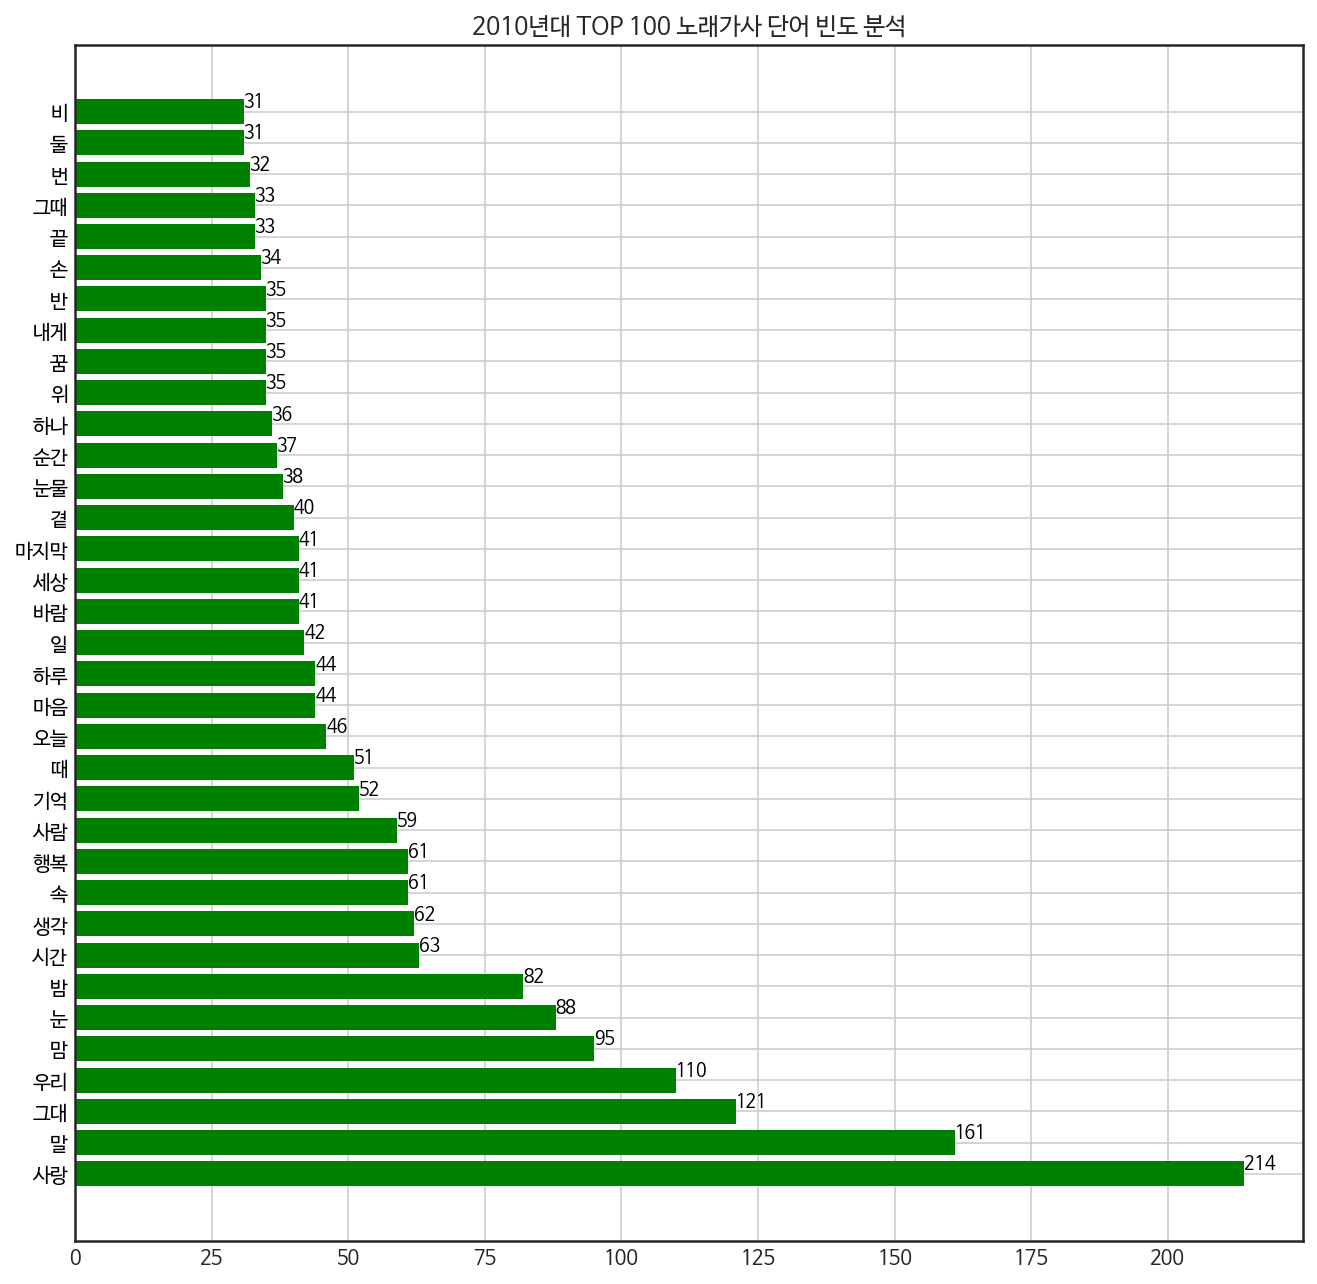

In [ ]:
count_2010_key = [elem[0] for elem in count_2010]
count_2010_value = [elem[1] for elem in count_2010]

# matplotlib
y_pos = np.arange(len(count_2010))

plt.figure(figsize=(11,11))
plt.barh(y_pos, count_2010_value, color='g')
plt.rc('ytick', labelsize=15)  # y축 눈금 폰트 크기
plt.yticks(y_pos, count_2010_key, color='black')

for i, yi in enumerate(y_pos):
    plt.text(count_2010_value[i], yi, count_2010_value[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='black',
             horizontalalignment='left',  # horizontal alignment (left, center, right)
             verticalalignment='bottom')    # vertical alignment (top, center, bottom)

plt.title('2010년대 TOP 100 노래가사 단어 빈도 분석')

# 눈금 간격
ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
# 보조선
plt.grid(True)

plt.show()

In [ ]:
count_2000_key = [elem[0] for elem in count_2000]
count_2000_value = [elem[1] for elem in count_2000]

# matplotlib
y_pos = np.arange(len(count_2000))

plt.figure(figsize=(11,11))
plt.barh(y_pos, count_2000_value, color='g')
plt.yticks(y_pos, count_2000_key, color='black')

for i, yi in enumerate(y_pos):
    plt.text(count_2000_value[i], yi, count_2000_value[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='black',
             horizontalalignment='left',  # horizontal alignment (left, center, right)
             verticalalignment='bottom')    # vertical alignment (top, center, bottom)

plt.title('2000년대 TOP 100 노래가사 단어 빈도 분석')

# 눈금 간격
ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
# 보조선
plt.grid(True)

plt.show()

In [ ]:
count_1990_key = [elem[0] for elem in count_1990]
count_1990_value = [elem[1] for elem in count_1990]

# matplotlib
y_pos = np.arange(len(count_1990))

plt.figure(figsize=(11,11))
plt.barh(y_pos, count_1990_value, color='g')
plt.yticks(y_pos, count_1990_key, color='black')

for i, yi in enumerate(y_pos):
    plt.text(count_1990_value[i], yi, count_1990_value[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='black',
             horizontalalignment='left',  # horizontal alignment (left, center, right)
             verticalalignment='bottom')    # vertical alignment (top, center, bottom)

plt.title('1990년대 TOP 100 노래가사 단어 빈도 분석')

# 눈금 간격
ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
# 보조선
plt.grid(True)

plt.show()

In [ ]:
count_1980_key = [elem[0] for elem in count_1980]
count_1980_value = [elem[1] for elem in count_1980]

# matplotlib
y_pos = np.arange(len(count_1980))

plt.figure(figsize=(11,11))
plt.barh(y_pos, count_1980_value, color='g')
plt.yticks(y_pos, count_1980_key, color='black')

for i, yi in enumerate(y_pos):
    plt.text(count_1980_value[i], yi, count_1980_value[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='black',
             horizontalalignment='left',  # horizontal alignment (left, center, right)
             verticalalignment='bottom')    # vertical alignment (top, center, bottom)

plt.title('1980년대 TOP 100 노래가사 단어 빈도 분석')

# 눈금 간격
ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
# 보조선
plt.grid(True)

plt.show()

IndexError: ignored

# 형태소 분석

In [ ]:
from tqdm import tqdm
from konlpy import tag
from collections import defaultdict

import math

In [ ]:
tokenizer = tag.Okt()

In [ ]:
def make_tokenized(data):
    tokenized = [] # 단어 단위로 나뉜 review data

    for sent in tqdm(data):
        tokens = tokenizer.morphs(sent)
        tokenized.append(tokens)

    return tokenized 

okt 형태소 처리기 참고
https://mr-doosun.tistory.com/22

In [ ]:
tokenizer.tagset

{'Adjective': '형용사',
 'Adverb': '부사',
 'Alpha': '알파벳',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Eomi': '어미',
 'Exclamation': '감탄사',
 'Foreign': '외국어, 한자 및 기타기호',
 'Hashtag': '트위터 해쉬태그',
 'Josa': '조사',
 'KoreanParticle': '(ex: ㅋㅋ)',
 'Noun': '명사',
 'Number': '숫자',
 'PreEomi': '선어말어미',
 'Punctuation': '구두점',
 'ScreenName': '트위터 아이디',
 'Suffix': '접미사',
 'Unknown': '미등록어',
 'Verb': '동사'}

In [ ]:
# 형태소중 명사, 동사, 형용사가 문장이 전하려는 의미를 담고있기에 해당 품사만 추출.
# 국내 가요에 한정하여 분석을 진행하기에, 영어단어는 크게 영향을 끼치지 않을 것이라 생각하여 생략함.
def stem_extract(data):
    stemes = []
    for document in data:
        clean_words = []
        for word in tokenizer.pos(document, stem=True): #어간 추출
            #if word[1] in ['Noun', 'Verb', 'Adjective']: #명사, 동사, 형용사
            if word[1] in ['Adjective']:
                clean_words.append(word[0])
        
        temp_str = ' '.join(clean_words)
        stemes.append(temp_str)

    return stemes

In [ ]:
# word count & remove stop word
# 여기선 유사 단어 병합과 불용어 제거 동시에 함
def remv_stop(lyrics_tokenized):
    stop_words = ['나', '내', '난', '날', '너', '널', '넌', '니', '네', '수', '거', '것', '걸', '건', '듯', '게', '순', '뿐', '이', '그', '하다']
    word_count = defaultdict(int) # Key : 단어, Value : 등장횟수

    for tokens in tqdm(lyrics_tokenized):
        for token in tokens:
            if token not in stop_words:
                    word_count[token] += 1               

    return word_count

### 2010년대

In [ ]:
lyrics_2010_stem = stem_extract(Lyrics_2010)
print(lyrics_2010_stem[0])

lyrics_2010_tokenized = make_tokenized(lyrics_2010_stem)
print(lyrics_2010_tokenized[0])

word_count_2010 = remv_stop(lyrics_2010_tokenized)

# reverse = True : 내림차순
word_count_2010 = sorted(word_count_2010.items(), key=lambda x: x[1], reverse=True)
print(len(word_count_2010)) # train data의 전체 단어 수

print(word_count_2010[:10])

없다 없다 많다 없다 많다 많다 좋다


100%|██████████| 100/100 [00:00<00:00, 162.09it/s]


['없다', '없다', '많다', '없다', '많다', '많다', '좋다']


100%|██████████| 100/100 [00:00<00:00, 34879.87it/s]

286
[('있다', 216), ('없다', 197), ('같다', 102), ('그렇다', 92), ('좋다', 79), ('아니다', 72), ('어떻다', 64), ('행복하다', 55), ('아프다', 54), ('좋아하다', 43)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


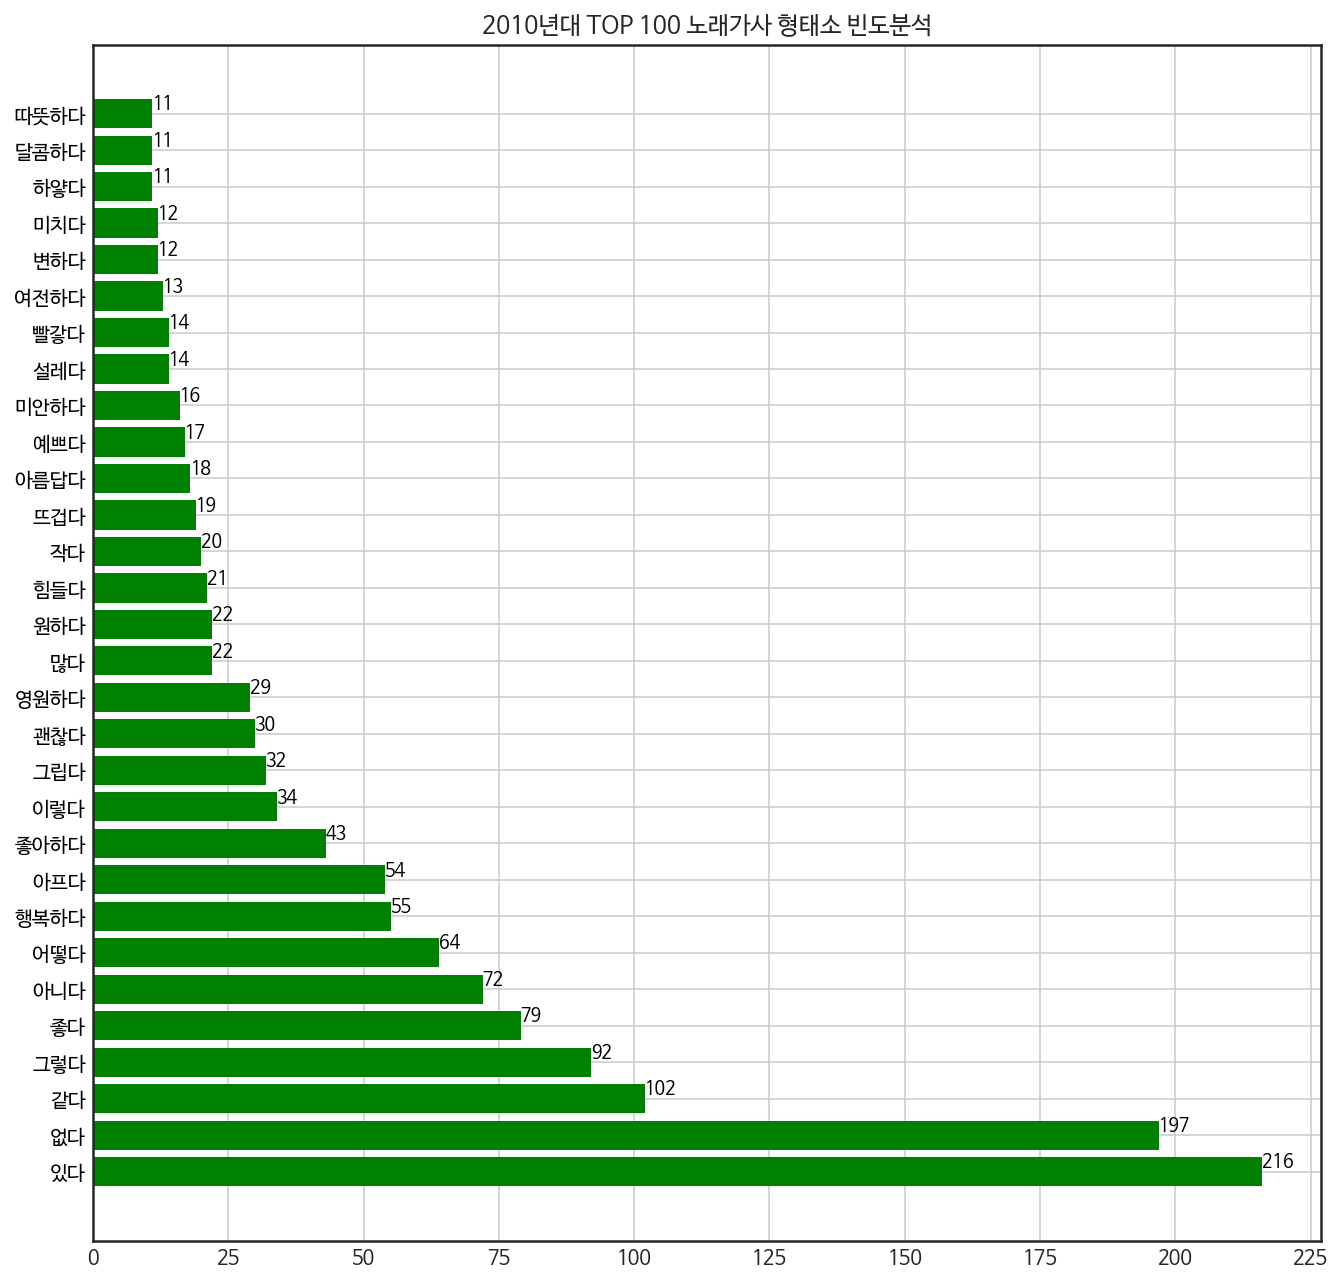

In [ ]:
key_2010 = [elem[0] for elem in word_count_2010[:30]]
val_2010 = [elem[1] for elem in word_count_2010[:30]]

# matplotlib
y_pos = np.arange(len(word_count_2010[:30]))

plt.figure(figsize=(11,11))
plt.barh(y_pos, val_2010, color='g')
plt.yticks(y_pos, key_2010, color='black')

for i, yi in enumerate(y_pos):
    plt.text(val_2010[i], yi, val_2010[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='black',
             horizontalalignment='left',  # horizontal alignment (left, center, right)
             verticalalignment='bottom')    # vertical alignment (top, center, bottom)

plt.title('2010년대 TOP 100 노래가사 형태소 빈도분석')

# 눈금 간격
ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
# 보조선
plt.grid(True)

plt.show()

### 2000년대

In [ ]:
lyrics_2000_stem = stem_extract(Lyrics_2000)
print(lyrics_2000_stem[0])

lyrics_2000_tokenized = make_tokenized(lyrics_2000_stem)
print(lyrics_2000_tokenized[0])

word_count_2000 = remv_stop(lyrics_2000_tokenized)

# reverse = True : 내림차순
word_count_2000 = sorted(word_count_2000.items(), key=lambda x: x[1], reverse=True)
print(len(word_count_2000)) # train data의 전체 단어 수

print(word_count_2000[:10])

멋지다 부끄럽다 없다 수줍다 어떻다 어떡하다 두근거리다 그렇다 좋다 예쁘다 예쁘다 뜨겁다 없다 후끈하다 좋다 좋다 수줍다 수줍다 친하다 좋다 부끄럽다 없다 어떡하다 좋다 있다 좋다 좋다


100%|██████████| 100/100 [00:00<00:00, 219.92it/s]


['멋지다', '부끄럽다', '없다', '수줍다', '어떻다', '어떡하다', '두근거리다', '그렇다', '좋다', '예쁘다', '예쁘다', '뜨겁다', '없다', '후끈하다', '좋다', '좋다', '수줍다', '수줍다', '친하다', '좋다', '부끄럽다', '없다', '어떡하다', '좋다', '있다', '좋다', '좋다']


100%|██████████| 100/100 [00:00<00:00, 53932.16it/s]

230
[('없다', 255), ('있다', 227), ('그렇다', 84), ('같다', 80), ('아프다', 79), ('아니다', 64), ('싫다', 56), ('좋다', 55), ('행복하다', 55), ('이렇다', 41)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


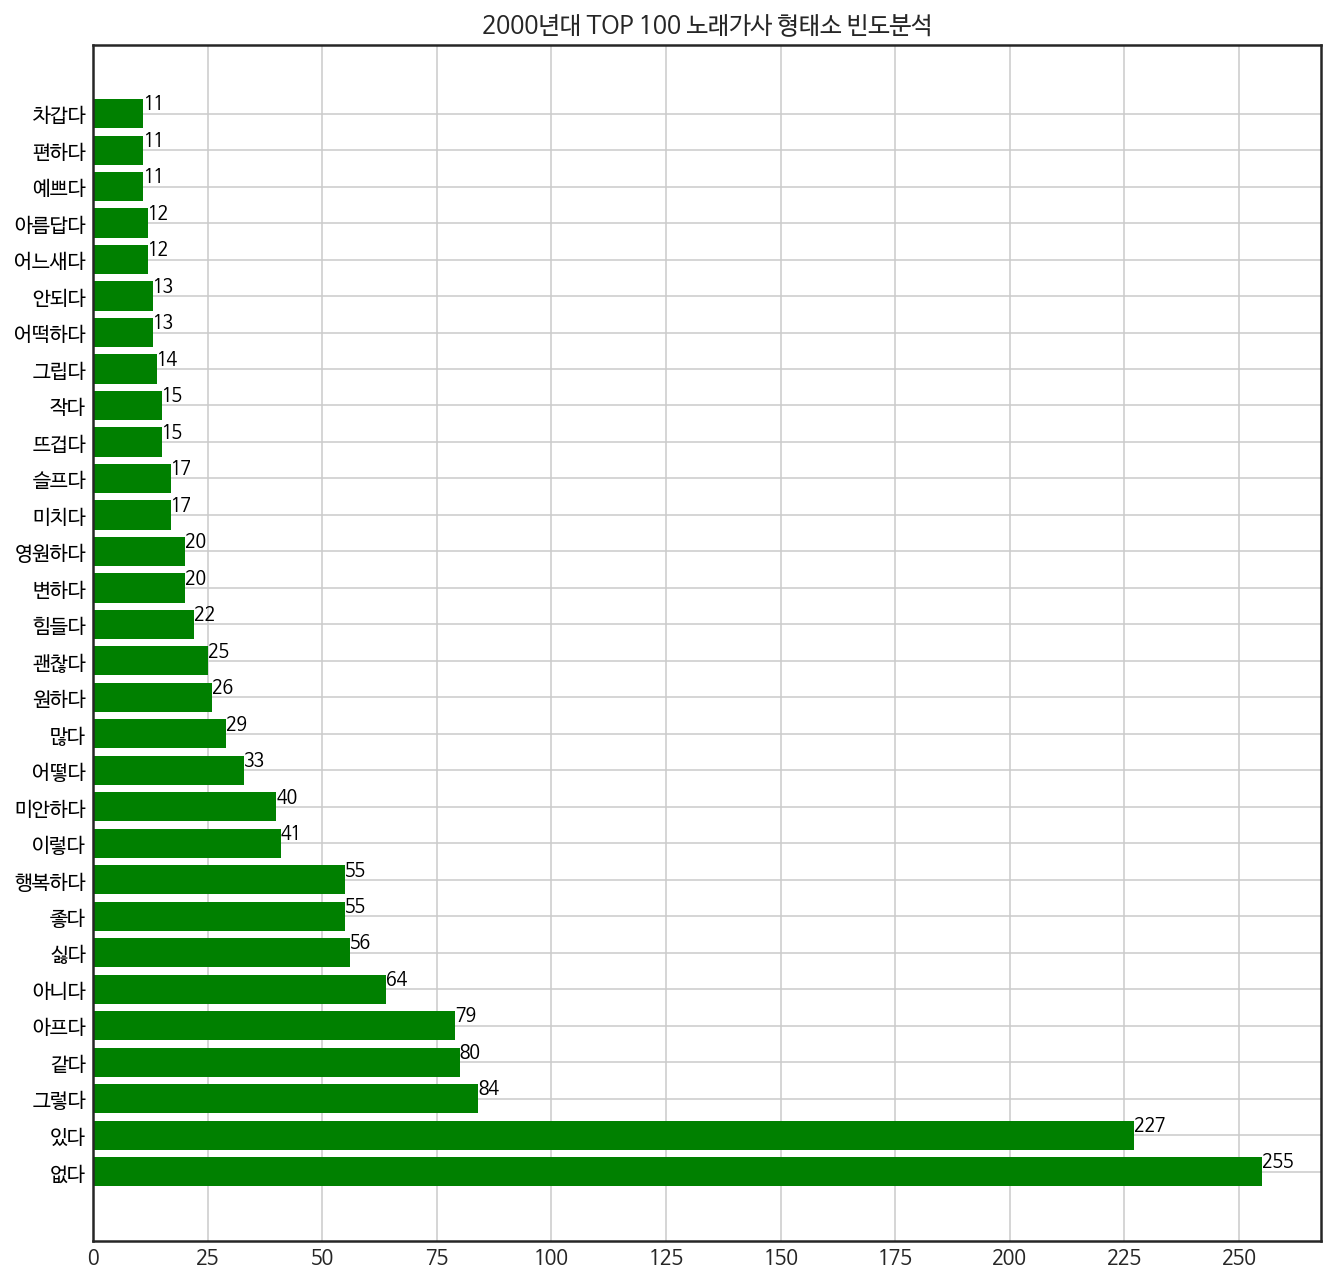

In [ ]:
key_2000 = [elem[0] for elem in word_count_2000[:30]]
val_2000 = [elem[1] for elem in word_count_2000[:30]]

# matplotlib
y_pos = np.arange(len(word_count_2000[:30]))

plt.figure(figsize=(11,11))
plt.barh(y_pos, val_2000, color='g')
plt.yticks(y_pos, key_2000, color='black')

for i, yi in enumerate(y_pos):
    plt.text(val_2000[i], yi, val_2000[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='black',
             horizontalalignment='left',  # horizontal alignment (left, center, right)
             verticalalignment='bottom')    # vertical alignment (top, center, bottom)

plt.title('2000년대 TOP 100 노래가사 형태소 빈도분석')

# 눈금 간격
ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
# 보조선
plt.grid(True)

plt.show()

### 1990년대

In [ ]:
lyrics_stem = stem_extract(Lyrics_1990)
print(lyrics_stem[0])

lyrics_tokenized = make_tokenized(lyrics_stem)
print(lyrics_tokenized[0])

word_count = remv_stop(lyrics_tokenized)

# reverse = True : 내림차순
word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
print(len(word_count)) # train data의 전체 단어 수

print(word_count[:10])

없다 많다 있다 아니다 아니다 멀다 길다 낯설다 멀다 여리다 아프다 있다 힘겹다 여리다 아프다 있다 힘겹다


100%|██████████| 100/100 [00:00<00:00, 294.42it/s]


['없다', '많다', '있다', '아니다', '아니다', '멀다', '길다', '낯설다', '멀다', '여', '리다', '아프다', '있다', '힘겹다', '여', '리다', '아프다', '있다', '힘겹다']


100%|██████████| 100/100 [00:00<00:00, 57566.62it/s]

165
[('있다', 269), ('없다', 175), ('그렇다', 70), ('슬프다', 63), ('많다', 47), ('같다', 44), ('좋다', 33), ('아니다', 28), ('아프다', 27), ('작다', 27)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


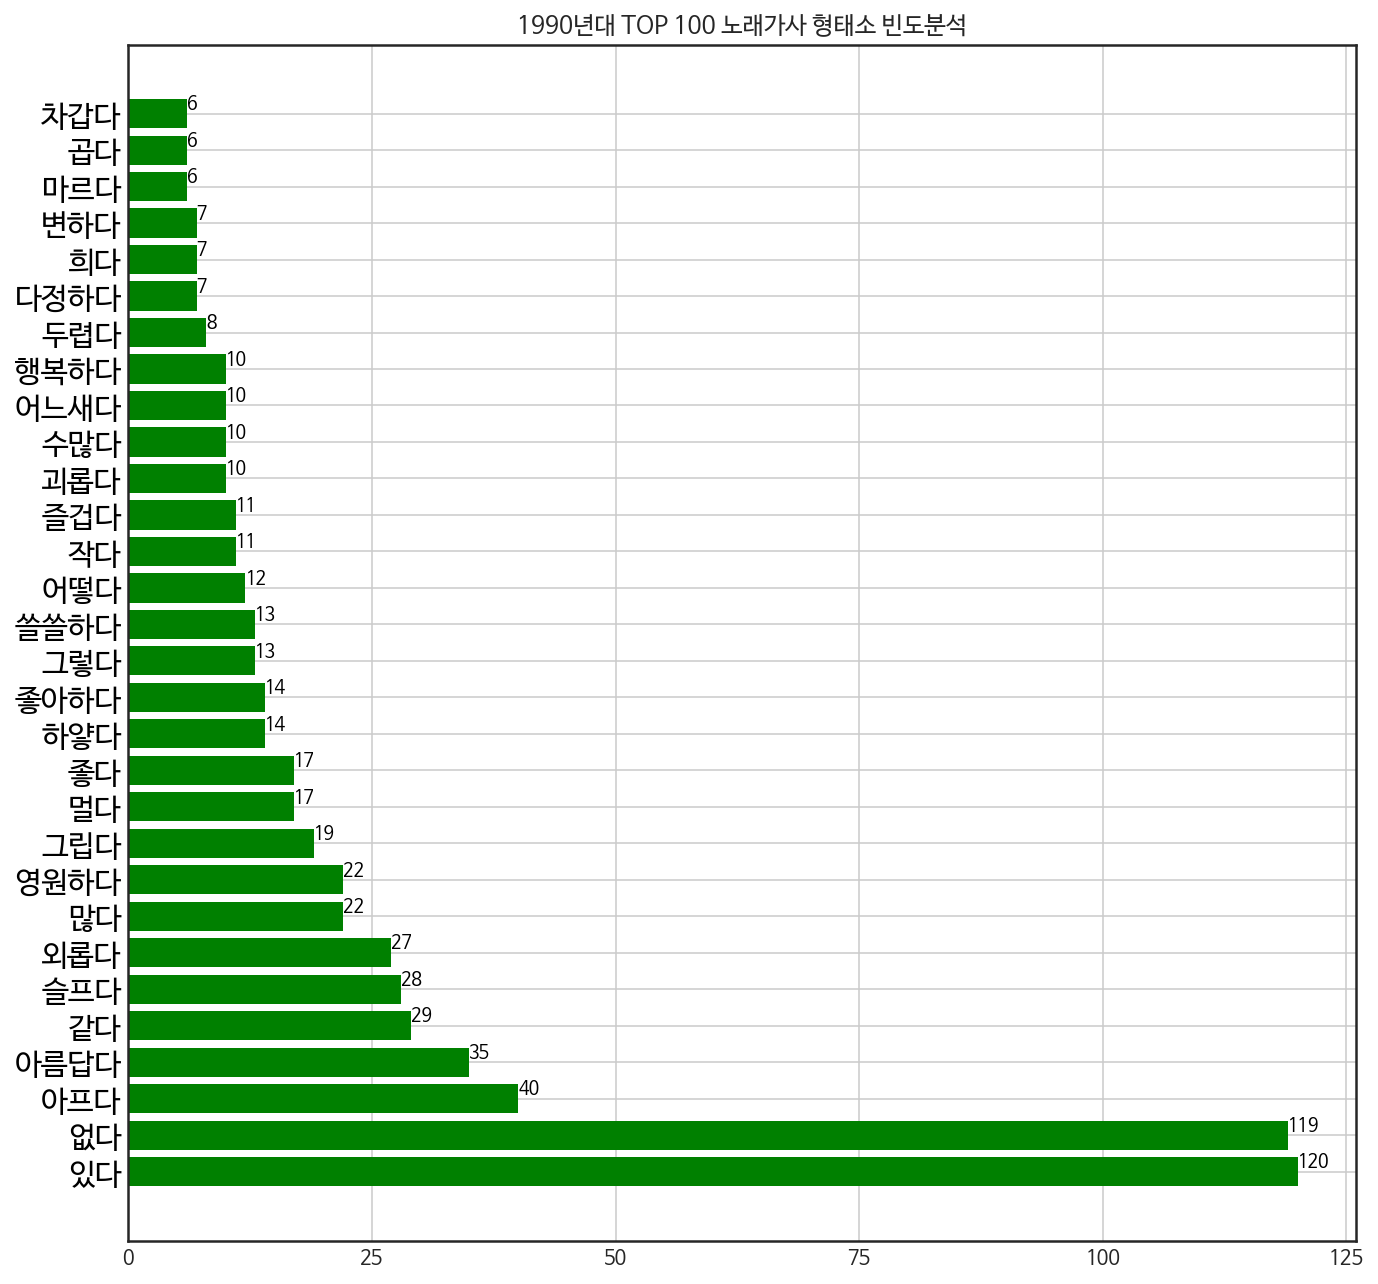

In [ ]:
key_1990 = [elem[0] for elem in word_count[:30]]
val_1990 = [elem[1] for elem in word_count[:30]]

# matplotlib
y_pos = np.arange(len(word_count[:30]))

plt.figure(figsize=(11,11))
plt.barh(y_pos, val, color='g')
plt.yticks(y_pos, key, color='black')

for i, yi in enumerate(y_pos):
    plt.text(val[i], yi, val[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='black',
             horizontalalignment='left',  # horizontal alignment (left, center, right)
             verticalalignment='bottom')    # vertical alignment (top, center, bottom)

plt.title('1990년대 TOP 100 노래가사 형태소 빈도분석')

# 눈금 간격
ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
# 보조선
plt.grid(True)

plt.show()

### 1980년대

In [ ]:
lyrics_stem = stem_extract(Lyrics_1980)
print(lyrics_stem[0])

lyrics_tokenized = make_tokenized(lyrics_stem)
print(lyrics_tokenized[0])

word_count = remv_stop(lyrics_tokenized)

# reverse = True : 내림차순
word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
print(len(word_count)) # train data의 전체 단어 수

print(word_count[:10])

깊다 멀다 더하다 멀다


100%|██████████| 100/100 [00:00<00:00, 615.26it/s]


['깊다', '멀다', '더하다', '멀다']


100%|██████████| 100/100 [00:00<00:00, 85563.12it/s]

132
[('있다', 120), ('없다', 119), ('아프다', 40), ('아름답다', 35), ('같다', 29), ('슬프다', 28), ('외롭다', 27), ('많다', 22), ('영원하다', 22), ('그립다', 19)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


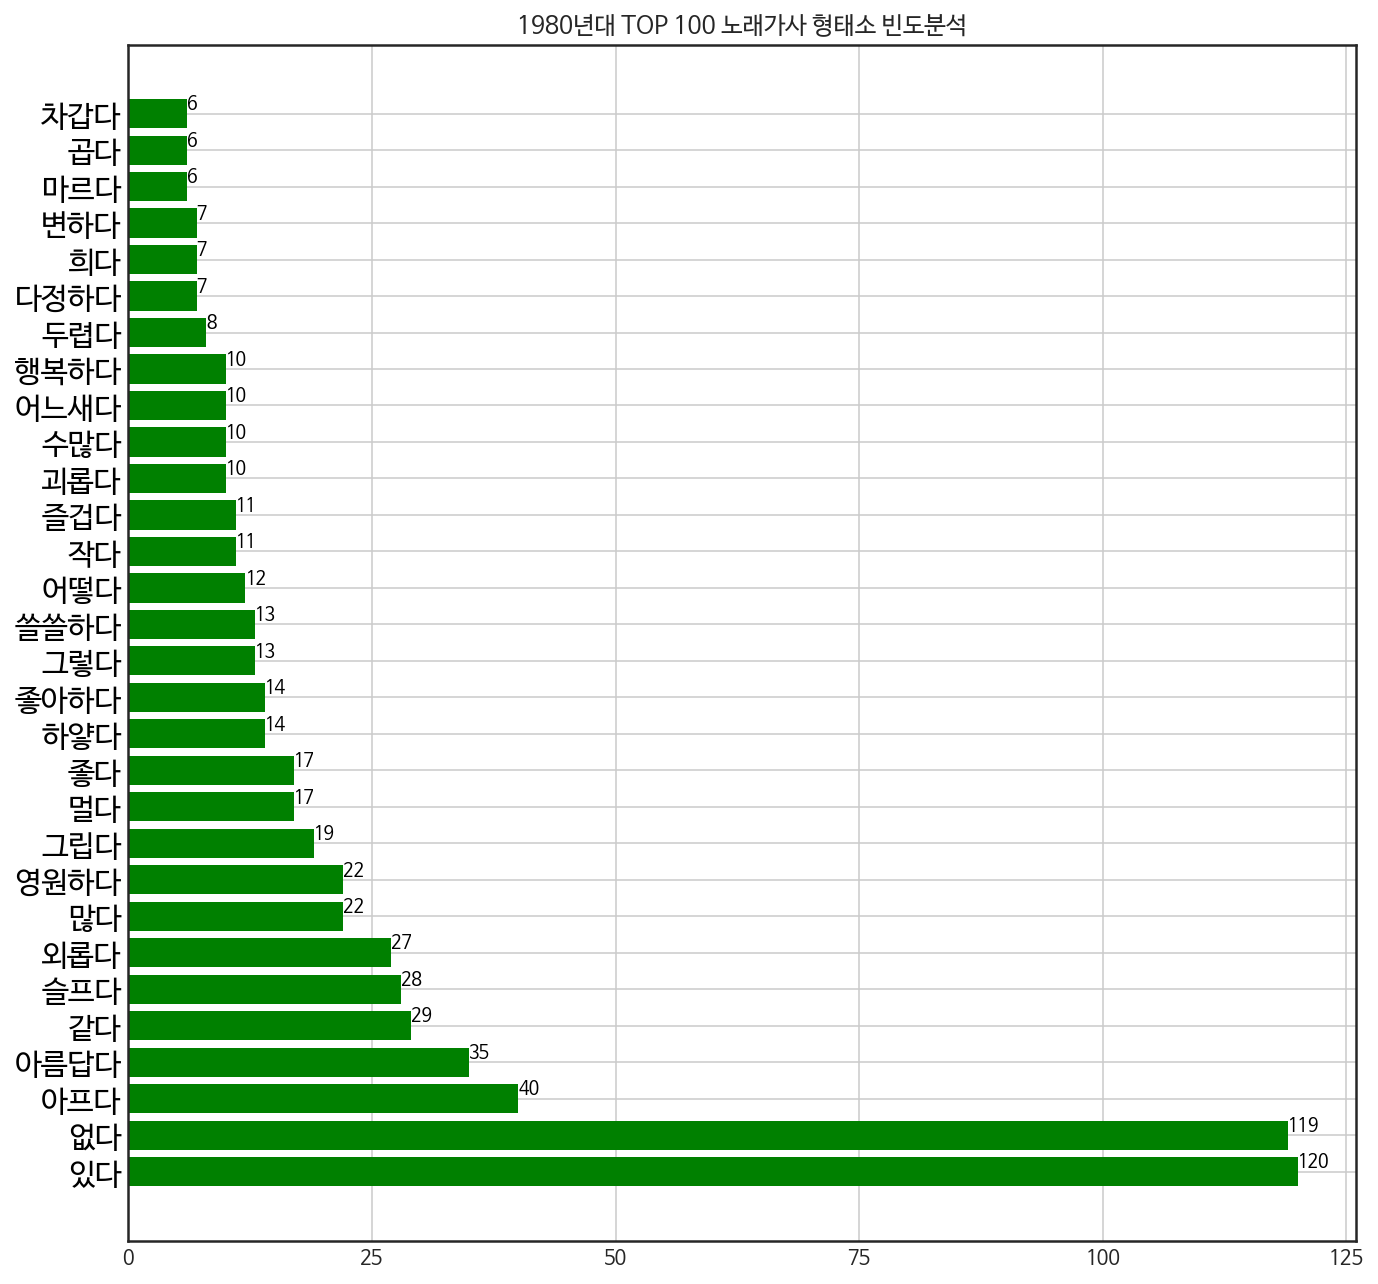

In [ ]:
key_1980 = [elem[0] for elem in word_count[:30]]
val_1980 = [elem[1] for elem in word_count[:30]]

# matplotlib
y_pos = np.arange(len(word_count[:30]))

plt.figure(figsize=(11,11))
plt.barh(y_pos, val, color='g')
plt.yticks(y_pos, key, color='black')

for i, yi in enumerate(y_pos):
    plt.text(val[i], yi, val[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='black',
             horizontalalignment='left',  # horizontal alignment (left, center, right)
             verticalalignment='bottom')    # vertical alignment (top, center, bottom)

plt.title('1980년대 TOP 100 노래가사 형태소 빈도분석')

# 눈금 간격
ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
# 보조선
plt.grid(True)

plt.show()

## 긍/부정 형용사 추이

In [ ]:
def find_rank(key, value):
    FIND = ['아프다', '행복하다', '아름답다', '좋다', '힘들다', '외롭다', '슬프다']
    F = []
    rank = 0
    for k, v in zip(key, value):
        rank+=1
        if k in FIND:
            F.append([rank, k, v])
    
    return F

In [ ]:
F_2010 = find_rank(key_2010, val_2010)
F_2000 = find_rank(key_2000, val_2000)
F_1990 = find_rank(key_1990, val_1990)
F_1980 = find_rank(key_1980, val_1980)

print(F_2010, F_2000, F_1990, F_1980, sep='\n')

[[5, '좋다', 79], [8, '행복하다', 55], [9, '아프다', 54], [17, '힘들다', 21], [20, '아름답다', 18]]
[[5, '아프다', 79], [8, '좋다', 55], [9, '행복하다', 55], [16, '힘들다', 22], [20, '슬프다', 17], [27, '아름답다', 12]]
[[4, '슬프다', 63], [7, '좋다', 33], [9, '아프다', 27], [13, '외롭다', 22], [15, '행복하다', 18], [16, '힘들다', 17], [22, '아름답다', 13]]
[[3, '아프다', 40], [4, '아름답다', 35], [6, '슬프다', 28], [7, '외롭다', 27], [12, '좋다', 17], [23, '행복하다', 10]]


[16, '힘들다', 17]
[16, '힘들다', 22]
[17, '힘들다', 21]


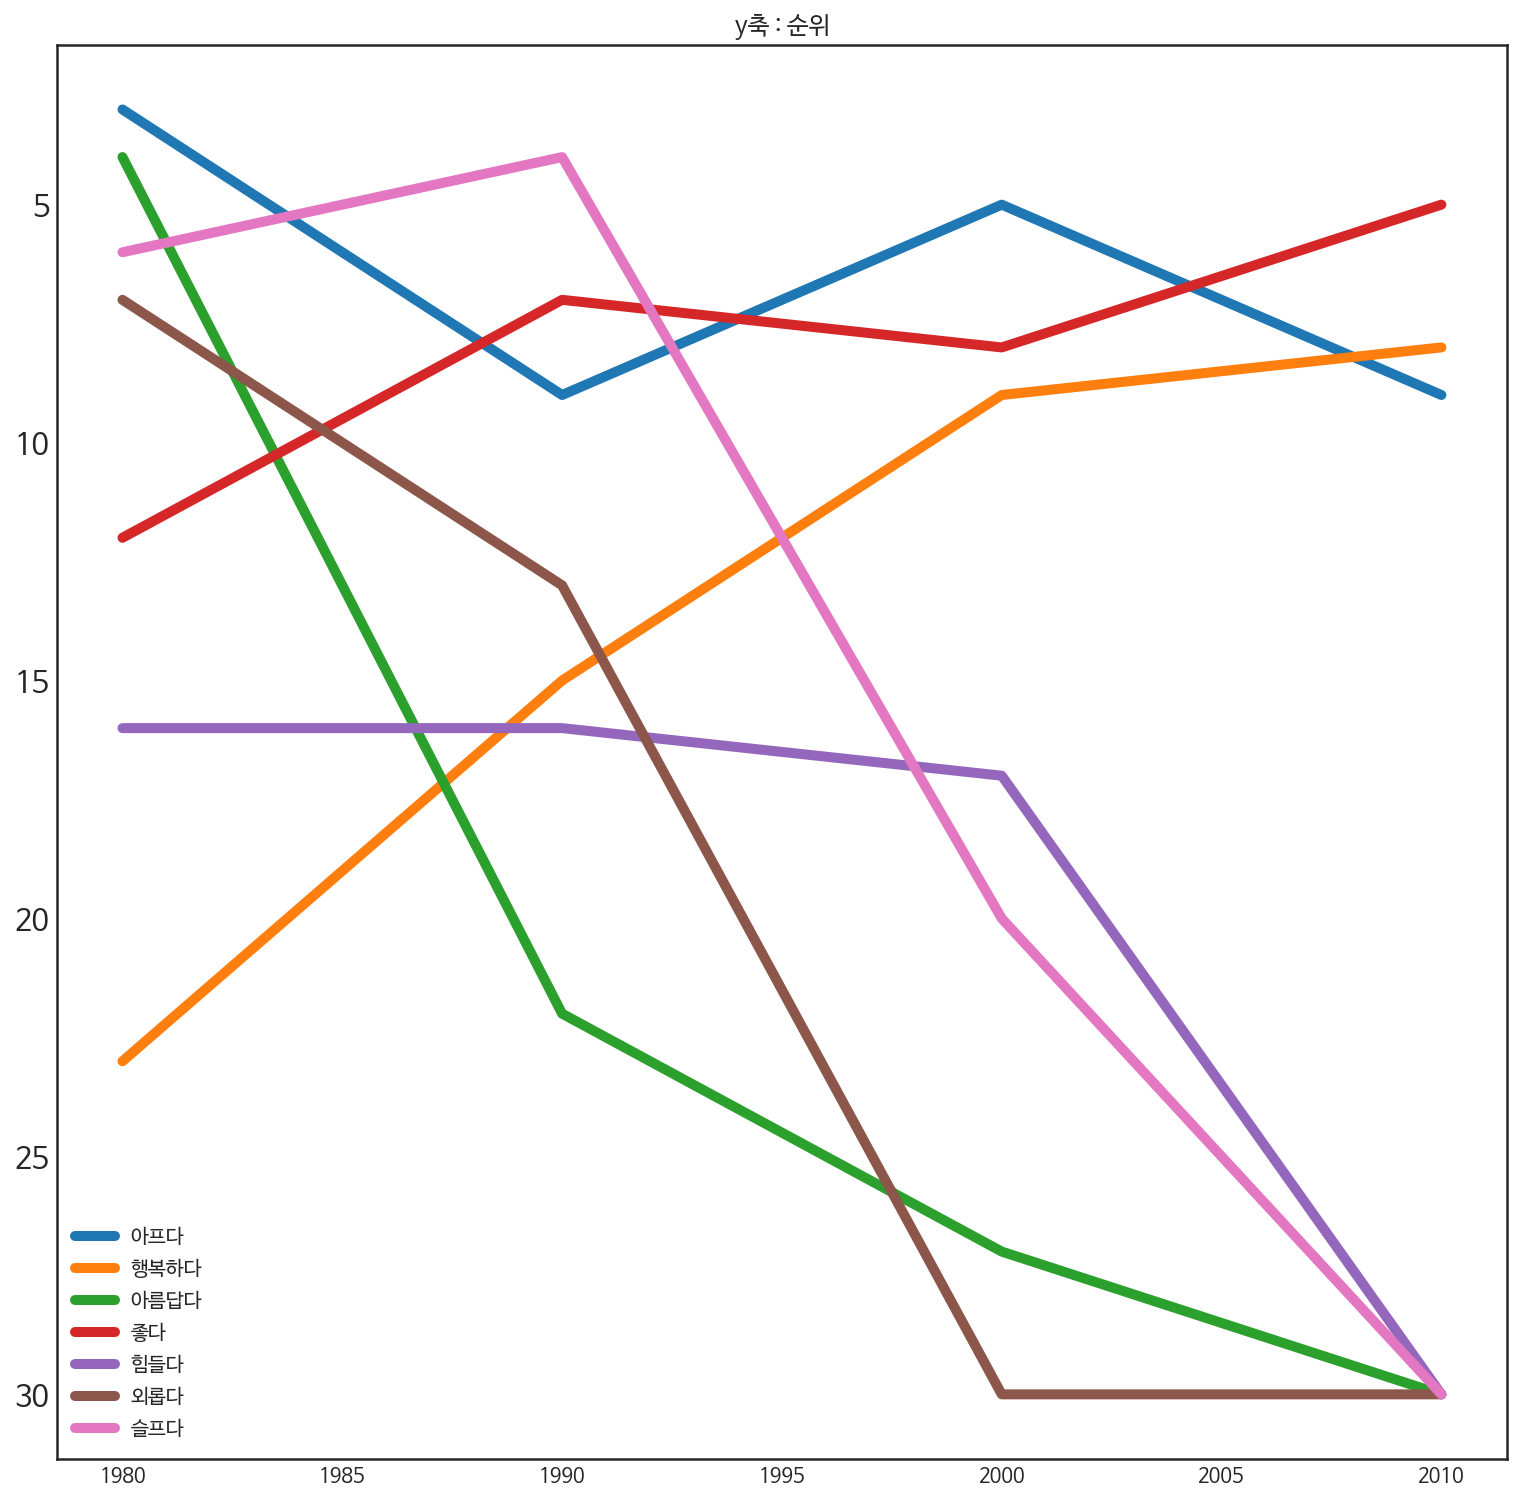

In [ ]:
FIND = ['아프다', '행복하다', '아름답다', '좋다', '힘들다', '외롭다', '슬프다']
F = F_1980 + F_1990 + F_2000 + F_2010

cp1 = len(F_1980)
cp2 = len(F_1990) + cp1
cp3 = len(F_2000) + cp2
cp4 = len(F_2010) + cp3

x = [1980, 1990, 2000, 2010]

plt.figure(figsize=(13, 13))
plt.gca().invert_yaxis()

y1 = []
for i in range(0, len(F)-1):
    if F[i][1] == FIND[0]:
        y1.append(F[i][0])
plt.plot(x, y1, linewidth=5)


y2 = []
for i in range(0, len(F)-1):
    if F[i][1] == FIND[1]:
        y2.append(F[i][0])
plt.plot(x, y2, linewidth=5)

y3 = [30, 30, 30, 30]
indx = 0
for i in range(0, len(F)-1):
    if 0 <= i and i < cp1:
        indx = 0
    elif i <= cp1 and i<cp2:
        indx = 1
    elif i <= cp2 and i<cp3:
        indx = 2
    else:
        indx = 3
    if F[i][1] == FIND[2]:
        y3[indx] = F[i][0]
        indx += 1
plt.plot(x, y3, linewidth=5)

y4 = []
for i in range(0, len(F)-1):
    if F[i][1] == FIND[3]:
        y4.append(F[i][0])
plt.plot(x, y4, linewidth=5)

y5 = [30, 30, 30, 30]
indx = 0
for i in range(0, len(F)-1):
    
    if F[i][1] == FIND[4]:
        print(F[i])
        y5[indx] = F[i][0]
        indx += 1
plt.plot(x, y5, linewidth=5)

y6 = [30, 30, 30, 30]
indx = 0
for i in range(0, len(F)-1):
    if F[i][1] == FIND[5]:
        y6[indx] = F[i][0]
        indx += 1
plt.plot(x, y6, linewidth=5)

y7 = [30, 30, 30, 30]
indx = 0
for i in range(0, len(F)-1):
    if F[i][1] == FIND[6]:
        y7[indx] = F[i][0]
        indx += 1
plt.plot(x, y7, linewidth=5)

plt.legend(['아프다', '행복하다', '아름답다', '좋다', '힘들다', '외롭다', '슬프다'])

plt.title("y축 : 순위")
plt.show()


11 1
16 2
22 3
3 0
9 1


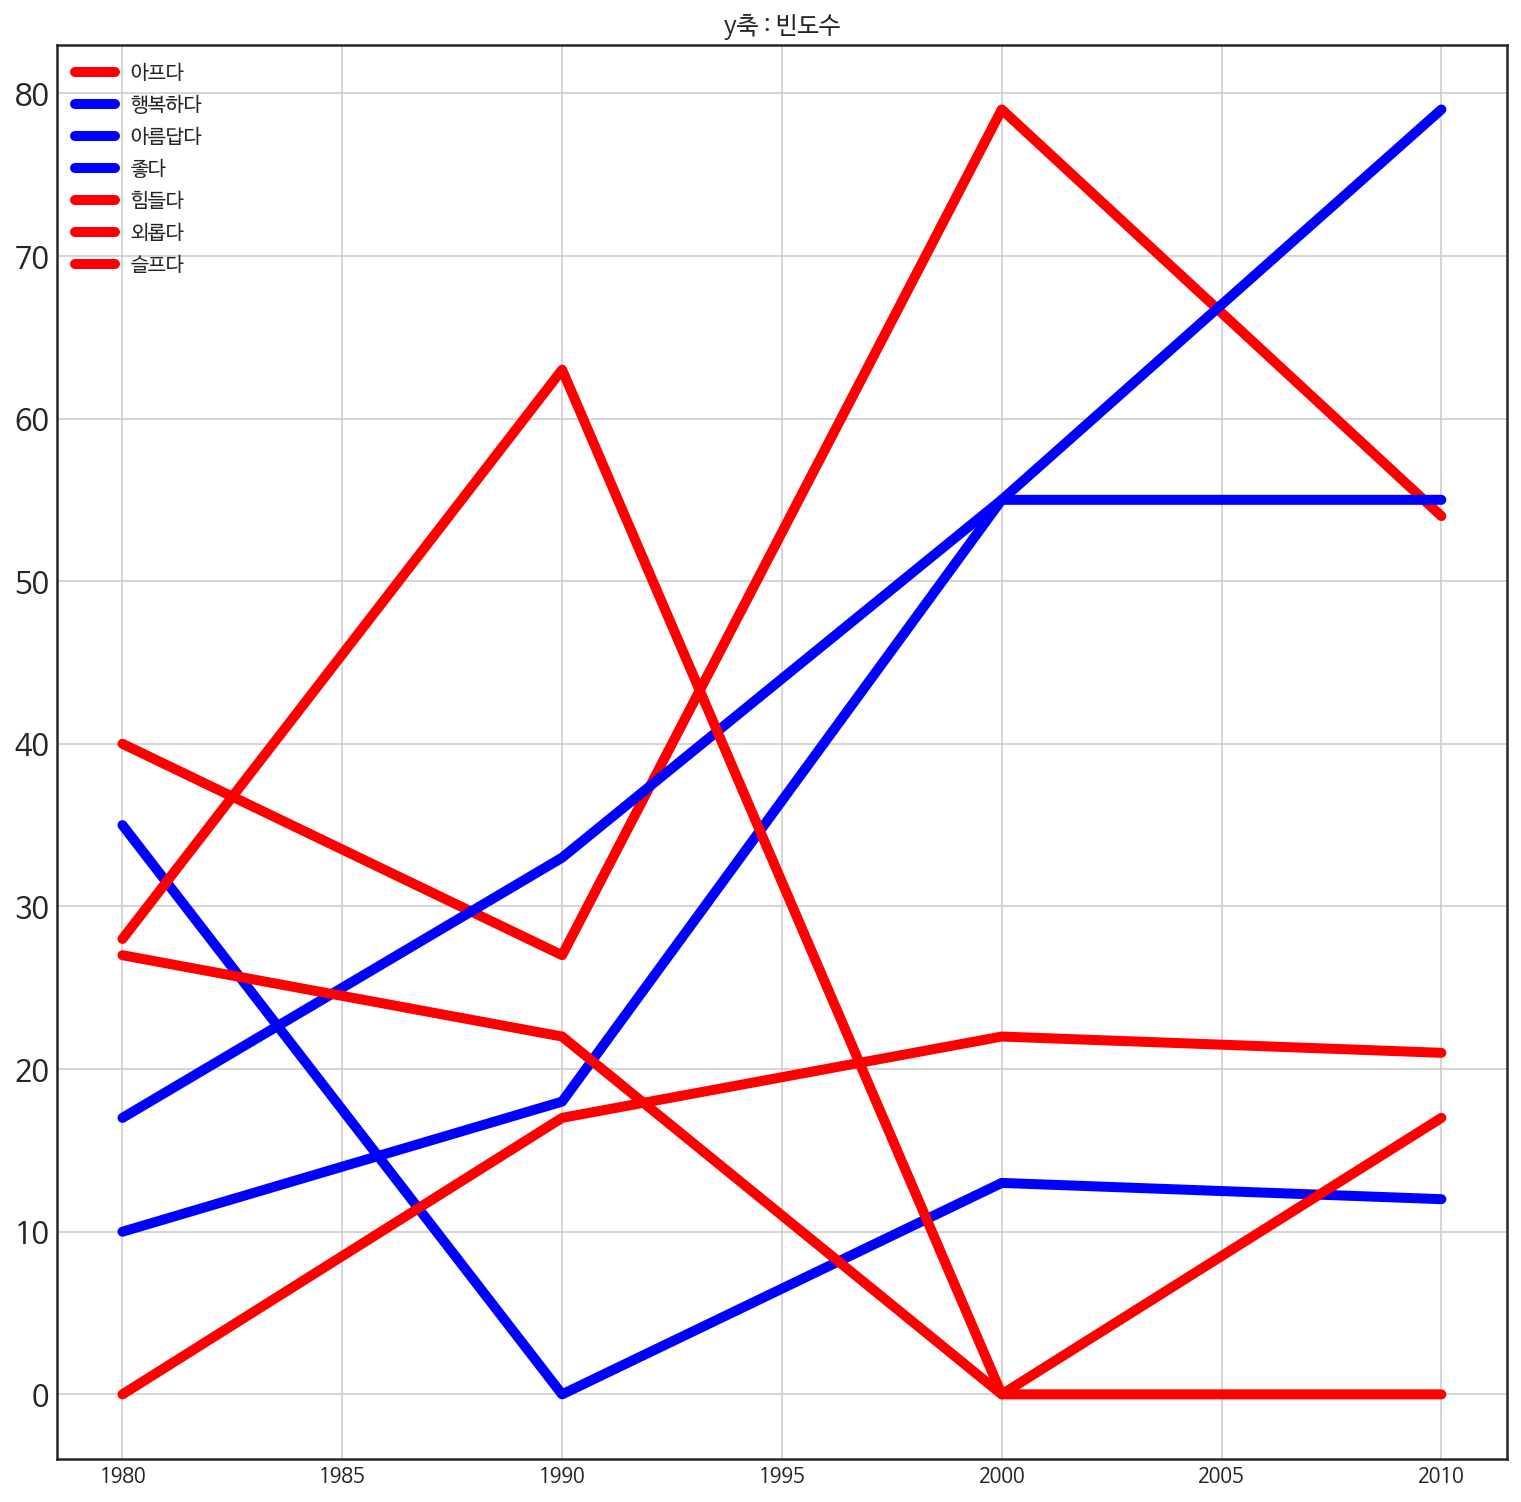

In [ ]:
FIND = ['아프다', '행복하다', '아름답다', '좋다', '힘들다', '외롭다', '슬프다']
F = F_1980 + F_1990 + F_2000 + F_2010

cp1 = len(F_1980)
cp2 = len(F_1990) + cp1
cp3 = len(F_2000) + cp2
cp4 = len(F_2010) + cp3

x = [1980, 1990, 2000, 2010]

plt.figure(figsize=(13, 13))

y1 = []
for i in range(0, len(F)-1):
    if F[i][1] == FIND[0]:
        y1.append(F[i][2])
plt.plot(x, y1, color='red', linewidth=5)


y2 = []
for i in range(0, len(F)-1):
    if F[i][1] == FIND[1]:
        y2.append(F[i][2])
plt.plot(x, y2, color='blue', linewidth=5)

y3 = [0, 0, 0, 0]
for i in range(0, len(F)-1):
    if 0 <= i and i < cp1:
        indx = 0
    elif i <= cp1 and i<cp2:
        indx = 1
    elif i <= cp2 and i<cp3:
        indx = 2
    else:
        indx = 3
    if F[i][1] == FIND[2]:
        y3[indx] = F[i][2]
plt.plot(x, y3, color='blue', linewidth=5)

y4 = []
for i in range(0, len(F)-1):
    if F[i][1] == FIND[3]:
        y4.append(F[i][2])
plt.plot(x, y4, color='blue', linewidth=5)

y5 = [0, 0, 0, 0]
indx = 0
for i in range(0, len(F)-1):
    if 0 <= i and i < cp1:
        indx = 0
    elif cp1 <= i and i<cp2:
        indx = 1
    elif cp2 <= i and i<cp3:
        indx = 2
    else:
        indx = 3
    if F[i][1] == FIND[4]:
        print(i, indx)
        y5[indx] = F[i][2]
plt.plot(x, y5, color='red', linewidth=5)

y6 = [0, 0, 0, 0]
indx = 0
for i in range(0, len(F)-1):
    if 0 <= i and i < cp1:
        indx = 0
    elif cp1 <= i and i<cp2:
        indx = 1
    elif cp2 <= i and i<cp3:
        indx = 2
    else:
        indx = 3
    if F[i][1] == FIND[5]:
        print(i, indx)
        y6[indx] = F[i][2]
plt.plot(x, y6, color='red', linewidth=5)

y7 = [0, 0, 0, 0]
indx = 0
for i in range(0, len(F)-1):
    if 0 <= i and i < cp1:
        indx = 0
    elif i <= cp1 and i<cp2:
        indx = 1
    elif i <= cp2 and i<cp3:
        indx = 2
    else:
        indx = 3
    if F[i][1] == FIND[6]:
        y7[indx] = F[i][2]

plt.plot(x, y7, color='red', linewidth=5)

plt.legend(['아프다', '행복하다', '아름답다', '좋다', '힘들다', '외롭다', '슬프다'])

plt.grid(True)
plt.title("y축 : 빈도수")
plt.show()

In [ ]:
print(len(F_1980), len(F_1990), len(F_2000), len(F_2010))
print(cp1, cp2, cp3, cp4)

6 7 6 5
6 13 19 24


In [ ]:
0 1 2 3 4 5
6 7 8 9 10 11 12
13 14 15 16 17 18 19
20 21 22 23


In [ ]:
print(y1, y2, y3, y4, y5, y6, y7, sep='\n')

[40, 27, 79, 54]
[10, 18, 55, 55]
[35, 0, 13, 12]
[17, 33, 55, 79]
[0, 17, 22, 21]
[27, 22, 0, 0]
[28, 63, 0, 17]
